(11)=
# Chapter 11: Nuclear Magnetic Resonance with nmrglue and nmrsim

In [1]:
%config InlineBackend.figure_format = 'svg'

Nuclear magnetic resonance (NMR) spectroscopy is one of the most common and powerful analytical methods used in modern chemistry. Up to this point, we having been primarily dealing with text-based data files - that is, files that can be opened with a text editor and still contain human comprehendible information. If you open most files that come out of an NMR instrument in a text editor, it will look more like gibberish than anything a human should be able to read. This is because they are *binary* files - they are written in computer language rather than human language.

We need a specialized module to be able to import and read these data, and luckily a Python library called nmrglue to does exactly this. The library contains modules for dealing with data from each of the major NMR spectroscopy file types which includes Bruker, Pipe, Sparky, and Varian. It does not read JEOL files, but as of this writing, JEOL spectrometers support exporting data into at least one of the above file types supported by nmrglue and direct support for JEOL files is under development.

In addition, it is also sometimes helpful to be able to simulate NMR spectra to confirm spectral parameters (e.g., coupling constants), visualize hypothetical spectra of splitting patterns, or fit the line shapes or splitting patterns of experimental data. The library nmrsim provides the ability to simulate NMR spectra including dynamic NMR and is introduced in [section 11.2](11.2).

(11.1)=
## 11.1 NMR Processing with nmrglue

```{index} single: NMR; processing
```

Currently, nmrglue is not included with default installation of Anaconda, so you will need to install it. Instructions are included on the [nmrglue documentation page](https://nmrglue.readthedocs.io/en/latest/index.html) or you can use `pip` to install it. If Jupyterlab is installed on your computer, you should be able to install it through the terminal using `pip install nmrglue`, and if you are using Google Colab, you should include `!pip install nmrglue` in the first code cell of the notebook (see [section 0.2](0.2)). nmrglue requires you have NumPy and SciPy installed, and matplotlib should also be installed for visualization.

All use of code below assumes the following imports with aliases. nmrglue is not a major library in the SciPy ecosystem, so the `ng` alias is not a strong convention but is used here for convenience and to be consistent with the online documentation.

In [2]:
import nmrglue as ng
import numpy as np
import matplotlib.pyplot as plt

The general procedure for collecting NMR data is to excite a given type of NMR-active nuclei with a radio-frequency pulse and allow them to relax. As they precess, their rotation leads to a voltage oscillation in the instrument at characteristic frequencies, and the spectrometer records these oscillations as a *free induction decay (fid)* depicted below (Figure 1, left). It is the frequency of these oscillations that we are interested in because they are informative to a trained chemist as to the chemical environment of the nuclei. One challenge is that all the different signals from each of the nuclei are stacked on top of each other making it difficult to distinguish one from the other or to determine the wave frequency. This is similar to the problem of a computer discerning a single instrument in an entire orchestra playing at once. Fortunately, there is a mathematical equation called the Fourier transform that converts the above *fid* into a graph showing all of the different frequencies (Figure 1, right). This is what is known as converting the *time domain* to the *frequency domain*.

![](img/fid.svg)

**Figure 1** Raw NMR spectroscopy data is converted from the time domain (left) to the frequency domain (right) using a Fourier transform.

The general steps for dealing with NMR spectroscopic data in Python are outlined below.

1. Load the fid data into a NumPy array using nmrglue

2. Fourier transform the data to the frequency domain

3. Phase the spectrum

4. Reference the spectrum

5. Measure the chemical shifts and integrals of the peaks

(11.1.1)=
### 11.1.1 Importing Data with nmrglue

```{index} single: file input/output; reading NMR data
```

The importing of data using nmrglue is performed by the read function from one of the submodules shown in Table 1. Additional modules can be found in the [nmrglue documention](https://nmrglue.readthedocs.io/en/latest/tutorial.html). The choice of module is dictated by the data file type.

**Table 1** Examples of nmrglue Modules

| Module | Description |
| :----: | :---------  |
|`bruker`| Bruker data as a single file |
|`pipe`  |Pipe data as a single file with an `.fid` extension |
|`sparky`|Sparky NMR file format with `.ucsf` extension |
|`varian`|Varian/Agilent data as a folder of data with an `.fid` extension |
|`jcampdx`|JCAMP-DX files with .dx or `.jdx` extensions|

The `read()` function loads the NMR file and returns a tuple containing a dictionary of metadata and data in a NumPy array. The dictionary includes information required to complete the processing of the NMR data. Looking at the NMR data shown below, you may have noticed each point includes both both real and imaginary components (i.e., the mathematical terms with `j`). Both are necessary for phasing the spectrum later on, so don't discard any of the data.

In [3]:
dic, data = ng.pipe.read('data/EtPh_1H_NMR_CDCl3.fid')
data

array([-0.00194889-0.00471539j, -0.00192186-0.00472489j,
       -0.00191337-0.00473085j, ..., -0.00189737+0.00591656j,
       -0.00191882+0.005872j  , -0.00191135+0.00587132j],
      shape=(13107,), dtype=complex64)

````{margin}
```{Note}
The data used in this demo was already Fourier transformed on the spectrometer, so the following cell reverses this process for demo purposed. Some spectrometers automatically Fourier transform the data while others do not.
```
````

In [4]:
# Reversed the Fourier transform for demo purposes being as this data 
# was colleced on a spectrometer that already Fourier transformed the data.

from scipy.fft import ifft
data = ifft(data)[::-1]

The dictionary, `dic`, above contains a very long list of values, and the dictionary keys can be different among different file formats. To maintain a shorter, more useful, and more consistent dictionary of metadata, nmrglue provides the `guess_udic()` function for generating a *universal dictionary* among all file formats.

In [5]:
udic = ng.pipe.guess_udic(dic, data)
udic

{'ndim': 1,
 0: {'sw': 5994.65478515625,
  'complex': True,
  'obs': 399.7821960449219,
  'car': 1998.9109802246094,
  'size': 13107,
  'label': 'Proton',
  'encoding': 'direct',
  'time': False,
  'freq': True}}

````{margin}
```{note}
In NMR spectroscopy, "1D NMR" is actually two-dimensional while "2D NMR" are actually three-dimensional.
```
````

The universal dictionary is a nested dictionary. The first key is `ndim` which provides the number of dimensions in the NMR spectrum. Most NMR spectra are one dimensional, but two dimensional is also fairly common. Subsequent key(s) are for each dimension in the NMR spectrum with the value as a nested dictionary of metadata. Because the data for the above spectrum is one-dimensional, there is only one nested dictionary. Table 2 below provides a description of each piece of metadata contained in the universal dictionary.

**Table 2** `udic` Dictionary Keys for Single Dimensions\*

|  Key  | Description  |  Data Type  |
| :---: | :--------    | :---------  |
|`car` | Carrier frequency (Hz) | Float |
|`complex` | Indicates if the data contain complex values | Boolean |
| `encoding` | Encoding format | String |
| `freq` | Indicates if the data are in the frequency domain | Boolean |
| `label` | Observed nucleus | String |
| `obs` | Observed frequency (MHz) | Float |
| `size` | Number of data points in spectrum | Integer |
| `sw` | Spectral width (Hz) | Float |
| `time` | Indicates if the data are in the time domain\** | Boolean |

\* That is, it is assumed that we are looking at single dimensions from the NMR data, so for example, we are looking at `udic[0]`.

\** Being that the data must be in either the frequency or time domain, the `freq` and `time` keywords effectively provide the same information.

(11.1.2)=
### 11.1.2 Fourier Transforming Data

```{index} single: Fourier transform; NMR
```

When the data is first imported, it is often in the time domain. You can confirm this by checking that the `time` value in the `udic` is set to `True` like below.

~~~python
udic[0]['time']
~~~

We can also view the data by plotting with matplotlib.

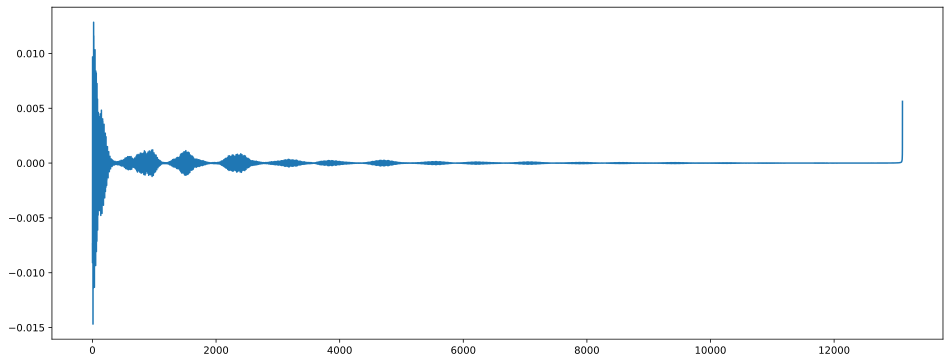

In [6]:
fig0 = plt.figure(figsize=(16, 6))
ax0 = fig0.add_subplot(1, 1, 1)
ax0.plot(data.real);

To convert the data to the frequency domain, we will use the fast Fourier transform function (`fft`) from the `fft` SciPy module. nmrglue also contains Fourier transform functions, but we will use SciPy here. The plot below inverts the *x*-axis with `plt.gca().invert_xaxis()` to conform to NMR plotting convensions.

In [7]:
from scipy.fft import fft
fdata = fft(data)

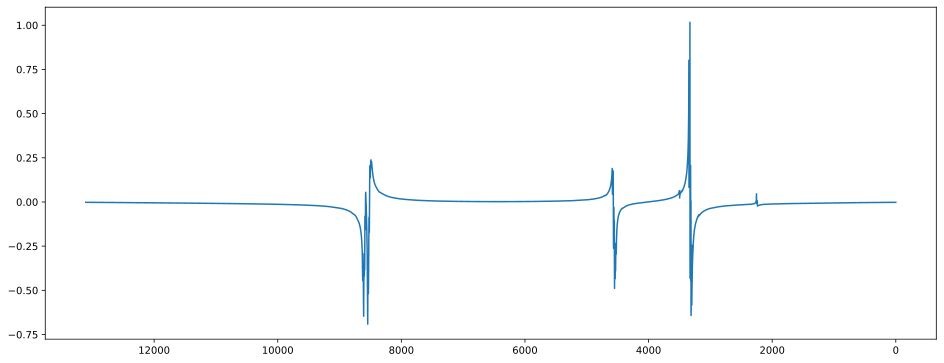

In [8]:
fig1 = plt.figure(figsize=(16, 6))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(fdata.real)
plt.gca().invert_xaxis() # reverses direction of x-axis to conform to NMR plotting norms

When you plot the Fourier transformed data, you may get a `ComplexWarning` error message because the Fourier transform will return complex values (i.e., values with real and imaginary components). To only work with the real components, use the `.real` method as is done above. The plot now looks more like an NMR spectrum, but most of the resonances are out of phase. The next step is to phase the spectrum.

(11.1.3)=
### 11.1.3 Phasing Data

Phasing is the post-processing procedure for making all peaks point upward as shown in Figure 2. There is more to it than taking the absolute value as that would not always generate a single peak, so nmrglue contains a series of functions for phasing spectra.

![](img/phasing.svg)

**Figure 2** Phasing an NMR spectrum results in all the signals pointing in the positive direction.

(11.1.3.1)=
#### 11.1.3.1 Autophasing

The simplest method to phase your NMR spectrum is to allow the autophasing function to handle it for you. Below is the function which takes the data and the phasing algorithm as the arguments.

~~~python
ng.process.proc_autophase.autops(data, algorithm)
~~~

The permitted phasing algorithms can be either `acme` or `peak_minima`. It is important to feed the `autops()` function the data array with *both* the real and imaginary components.

In [9]:
phased_data = ng.process.proc_autophase.autops(fdata, 'acme')

Optimization terminated successfully.
         Current function value: 0.001729
         Iterations: 117
         Function evaluations: 236


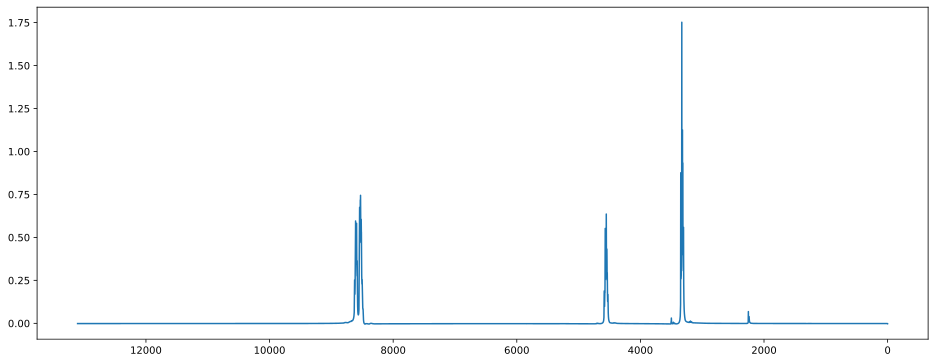

In [10]:
fig2 = plt.figure(figsize=(16, 6))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(phased_data.real)
plt.gca().invert_xaxis()

You should try both algorithms to see which works best for you. The above spectrum is the result of the `acme` autophasing algorithm which is close but still slightly off. If neither of the provided autophasing algorithms work for you, you will need to instead manually phase the NMR spectrum as discussed below.

(11.1.3.2)=
#### 11.1.3.2 Manual Phasing

Manually phasing the NMR spectrum is a two-step process. First, you need to call the `manual_ps()` phasing function and adjust the `p0` and `p1` sliders until the spectrum appears phased. 

~~~python
%matplotlib  # exists inline plotting
p0, p1 = ng.process.proc_autophase.manual_ps(fdata.real)
~~~

![](img/manual_phaseing_window.png)

After closing the window, the function will return values for `p0` and `p1` that you found to properly phase the spectrum. Second, input those `p0` and `p1` values into the `ps()` phasing function to actually phase the spectrum.

~~~python
phased_data = ng.proc_base.ps(fdata, p0=p0, p1=p1)

%matplotlib inline  # reinstates inline plotting

fig3 = plt.figure(figsize=(16,6))
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(phased_data.real)
plt.gca().invert_xaxis()
~~~

You can then plot the `phased_data` to get your NMR spectrum with all the peaks pointing upward.

(11.1.4)=
### 11.1.4 Chemical Shift

Even though the NMR spectrum is now phased, it is unlikely to be properly *referenced*. That is, the peaks are not currently located at the correct *chemical shift*. Referencing is often performed by knowing the accepted chemical shifts of the solvent resonances or an internal standard (e.g., tetramethylsilane, TMS) and adjusting the spectrum by a correction factor. Currently, we are plotting our data against the index of each data point, so first we need to create a frequency scaled *x*-axis as an array followed by adjusting the location of the spectrum so that it is properly referenced.  

(11.1.4.1)=
#### 11.1.4.1 Generate the X-Axis

The *x*-axis is the frequency scale, so this axis is sometimes presented in hertz (Hz). However, because the frequency of NMR resonances depends upon the instrument field strength, the same sample will exhibit different frequencies in different instruments. To make the frequency axis independent of the spectrometer field strength, NMR spectra are often presented on a *ppm scale* which is the ratio of the observed chemical shift (Hz) versus a standard over the spectrometer frequency (MHz) at which that particular nucleus is observed.

$$ ppm = \frac{Observed \, Frequency \, (Hz)}{Spectrometer \, Frequency \, (MHz)} $$

This makes the locations of the peaks consistent from spectrometer to spectrometer no matter the strength of the magnet. This is where the `udic` from [section 11.1.1](11.1.1) is important because we can obtained the observed frequency width (Hz) of the spectrum, and the resolution of the data. The latter is how many data points are in the spectrum which is important so that we avoid a plotting error (we all know the one: `ValueError: x and y must have same first dimension,...`). If any of the values from the `udic` are 999.99, this means the spectrometer did not record this piece of information and you will need to find it elsewhere.

In [11]:
size = udic[0]['size'] # points in data
sw = udic[0]['sw']     # width in Hz
obs = udic[0]['obs']   # carrier frequency

In [12]:
from math import floor
hz = np.linspace(0, floor(sw), size) # x-axis in Hz 
ppm = hz / obs                       # x-axis in ppm

Now if we plot the spectrum, we see it in a ppm scale.

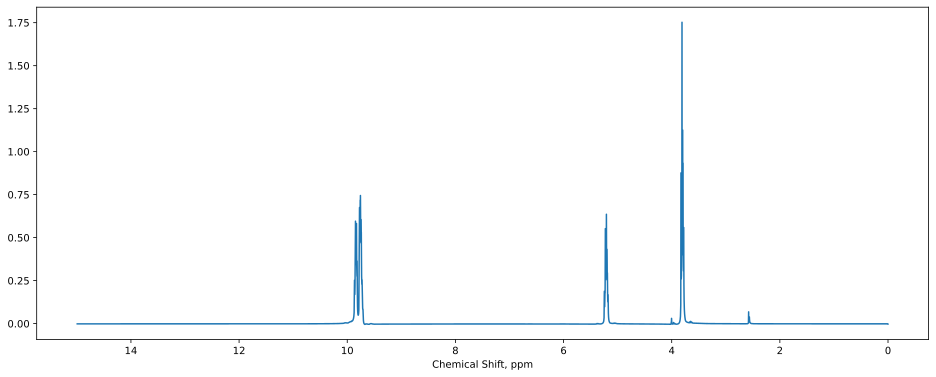

In [13]:
fig4 = plt.figure(figsize=(16,6))
ax4 = fig4.add_subplot(1,1,1)
ax4.plot(ppm, phased_data.real)
ax4.set_xlabel('Chemical Shift, ppm')
plt.gca().invert_xaxis()

Alternatively, nmrglue contains an object called a *unit conversion object* that can be created and used to convert between ppm, Hz, and point index values for any position in an NMR spectrum. To create a unit conversion object, use the `make_uc()` function which takes two arguments  – the dictionary, `dic`, and the original data array, `data`, generated from reading the NMR file in section 11.2. 

````{margin}
```{note}
If you are using a different NMR file format than pipe, change `pipe` to the appropriate format from Table 1.
```
````

~~~python
unit_conv = ng.pipe.make_uc(dic, data)   

ppm = unit_conv.ppm_scale()
~~~

The last line of the above code generates an array of ppm values required for the *x*-axis to plot the NMR data.

In [14]:
uc = ng.pipe.make_uc(dic, data)
ppm_scale = uc.ppm_scale()

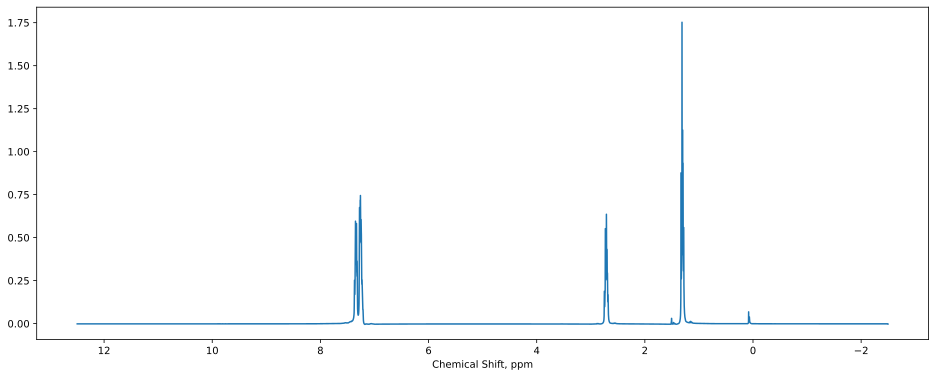

In [15]:
phased_data_rev = phased_data.real[::-1]

fig5 = plt.figure(figsize=(16, 6))
ax5 = fig5.add_subplot(1, 1, 1)
ax5.plot(ppm_scale, phased_data_rev)
ax5.set_xlabel('Chemical Shift, ppm')
plt.gca().invert_xaxis()

The following example uses the ppm scale generated by the unit conversion object.

(11.1.4.2)=
#### 11.1.4.2 Referencing the Data

In the above spectrum, the small resonance at 0.08 ppm is internal TMS (tetramethylsilane) standard which should be located at 0.00 ppm. The temptation is to subtract 0.08 ppm from the x-axis, but the spectrum is not simply moved over but instead is rolled. That is, as the spectrum is moved, some of it disappears off one end and reappears on the other (Figure 3). 

![](img/rolling.svg)

**Figure 3** Referencing an NMR spectrum is performing by rolling it until the peaks reside at the correct shifts. As a signal falls of one end of the spectrum, it reappears at the other end.

Conveniently for us, NumPy has a function `np.roll()` that does exactly this to array data, and nmrglue contains its own `ng.process.proc_base.roll()` function for this task which calls the NumPy function. Feel free to use either one.

~~~python
np.roll(array, shift)
~~~

The `np.roll()` function takes two required arguments. The first is the array containing the data and the second is the amount to shift or roll the data. The shift is not in ppm but rather positions in the data array. If you know your referencing correction in ppm (Δppm), use the following equation which describes the relationship between the correction in ppm (Δppm) and the correction in number of data points (Δpoints). The `size` is the number of point in a spectrum, `obs` is the observed carrier frequency, and `sw` is the sweep width in Hz. These values are all available from the universal dictionary.

$$ \Delta_{points} = \frac{\Delta_{ppm} \times size \times obs}{sw}  $$

Alternatively, you can accomplisht this same calculation using the unit conversion object by determing the data point difference between 0.00 ppm and the current position of the TMS. The example below requires the spectrum to be shifted by -0.08 ppm, and both approaches are demonstrated below.

In [16]:
ref_shift_manual = int((0.08 * size * obs) / sw) # calc shift yourself
# OR
ref_shift_uc = uc('0.00 ppm') - uc('0.08 ppm') # calc shift using unit conversion object

data_ref = np.roll(phased_data_rev, ref_shift_uc)

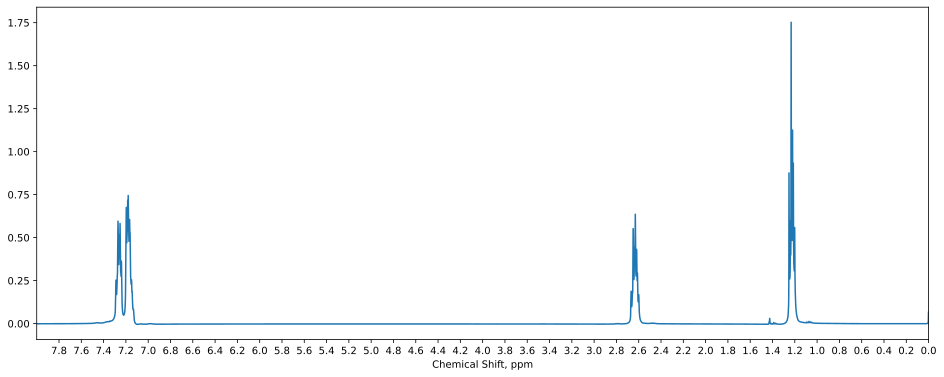

In [17]:
fig6 = plt.figure(figsize=(16, 6))
ax6 = fig6.add_subplot(1, 1, 1)
ax6.plot(ppm_scale, data_ref.real)
ax6.set_xlabel('Chemical Shift, ppm')
plt.xlim(8, 0)
plt.xticks(np.arange(0, 8, 0.2))
plt.show()

If you want to narrow the plot to where the resonances are located, you can use the `plt.xlim(8,0)` function. Notice that 8 is first to indicate that the plot is from 8 ppm $\rightarrow$ 0 ppm. The use of `plt.xlim(8,0)` removes the need to use `plt.gca().invert_xaxis()` to flip the *x*-axis. 

(11.1.5)=
### 11.1.5 Integration

Integration of the area under the peaks can be performed using either integration functions from the `scipy.integrate` module or though nmrglue’s integration function(s). Because the integration function in nmrglue supports limit values in the ppm scale, it is probably the most convenient and is demonstrated below.

The integration is performed using the `integrate()` function below where `data` is your NMR data as a NumPy array, the `conv_obj` is an nmrglue unit conversion object (see [section 11.1.4.1](11.1.4.1)), and limits is a list or array of limits for integration. 

~~~python
ng.analysis.integration.integrate(data, conv_obj, limits)
~~~

In [18]:
uc = ng.pipe.make_uc(dic, phased_data_rev)

In [19]:
limits = np.array([[7.07,7.37], [1.10, 1.35], [2.50,2.75]])

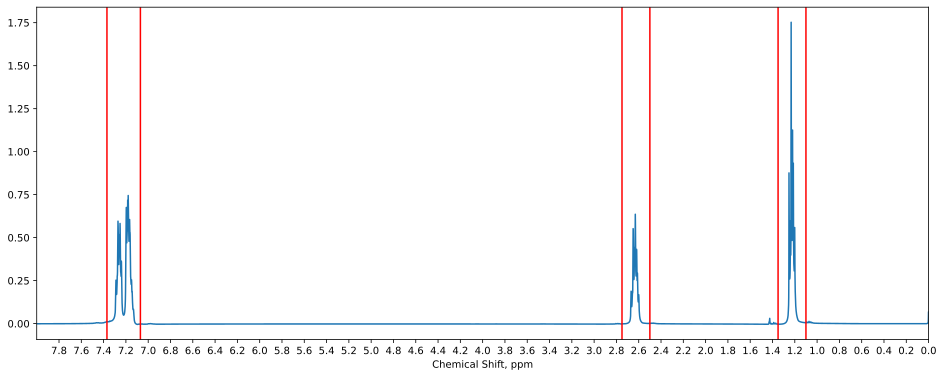

In [20]:
fig7 = plt.figure(figsize=(16, 6))
ax7 = fig7.add_subplot(1, 1, 1)
ax7.plot(ppm_scale, data_ref.real)
ax7.set_xlabel('Chemical Shift, ppm')
plt.xlim(8,0)
plt.xticks(np.arange(0, 8, 0.2))
for lim in limits.flatten():
    plt.axvline(lim, c='r')

The limits are in ppm, so take a look at the spectrum above and decide where you want to put the integration limits. An NMR spectrum with the chosen integration limits are shown above as vertical red lines.

Now to integrate our NMR spectrum.

In [21]:
area = ng.analysis.integration.integrate(data_ref.real, uc, limits)
area

array([0.05381569, 0.03379756, 0.02178194])

These values are probably not what you expected, but if we divide all of them by the smallest value, it is easier to see the relative ratio of areas.

In [22]:
ratio = area / np.min(area)
ratio

array([2.47065636, 1.55163197, 1.        ])

The spectrum above is the $^1$H NMR of ethylbenzene in CDCl$_3$ which has five aromatic protons, and the other two resonances should have three and two protons. If we do some math to make the integrations total to ten protons and round to the nearest integer, we get 5:3:2. There is a small amount of error likely due to the solvent resonance (CHCl$_3$, 7.27 ppm) being included in the integration of the aromatic protons among other things.

In [23]:
10 / np.sum(ratio) * ratio

array([4.91938374, 3.08949203, 1.99112423])

(11.1.6)=
### 11.1.6 Peak Picking

Another piece of information that is commonly extracted from NMR spectra is the chemical shift of the resonances. Similar to integration, SciPy contains functions such as [`scipy.signal.argrelmax()`](6.1.2) or [`scipy.signal.find_peaks()`](6.1.3) that can find peaks in spectra, but again, nmrglue contains a function, below, designed for the task of locating peaks in NMR spectra.

~~~python
ng.analysis.peakpick.pick(data, pthres=)
~~~

There are numerous optional arguments for the peak picking function, but the two mandatory pieces of information required are the `data` array and a positive threshold (`pthres=`) above which any peak will be identified. Glancing at the spectrum below, all peaks are above 0.1 (green dotted line) and the baseline is below 0.1, so this seems like a reasonable threshold.

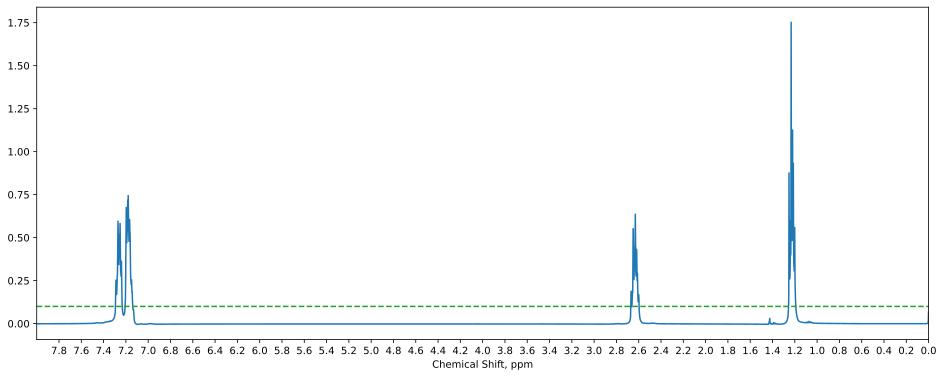

In [24]:
fig8 = plt.figure(figsize=(16, 6))
ax8 = fig8.add_subplot(1, 1, 1)
ax8.plot(ppm_scale, data_ref.real)
ax8.set_xlabel('Chemical Shift, ppm')
plt.xlim(8, 0)
plt.xticks(np.arange(0, 8, 0.2))
plt.axhline(0.1, c='C2', ls='--');

```{note}
The `ng.analysis.peakpick.pick()` does not work with NumPy versions 1.24 and later if you are using a version of nmrglue before 0.10. Consider upgrading your version of nmrglue if `ng.analysis.peakpick.pick()` raises an error.
```

In [25]:
peaks = ng.analysis.peakpick.pick(data_ref.real, pthres=0.1)
peaks

rec.array([(4568., 1, 32.13860124, 17.82116699),
           (4648., 2, 35.96968658, 25.60328484),
           (8591., 3,  5.        ,  0.88379395),
           (8624., 4, 31.36229043, 16.87084198),
           (9846., 5, 34.1857674 , 27.6301403 )],
          dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')])

The output of this function is an array of tuples with each tuple containing information about an identified peak. From this, we can already tell there are four peaks identified. Each tuple contains an index for the peak, a peak number, a line width of the peak, and an estimate of the areas of each peak. We can use the index values to index the `ppm` array for the chemical shifts.

In [26]:
peak_loc = []
for x in peaks:
    peak_loc.append(ppm_scale[int(x[0])])
print(peak_loc)

[np.float64(7.270899450723067), np.float64(7.17937704723959), np.float64(2.6684665855476872), np.float64(2.6307135941107536), np.float64(1.232708880900633)]


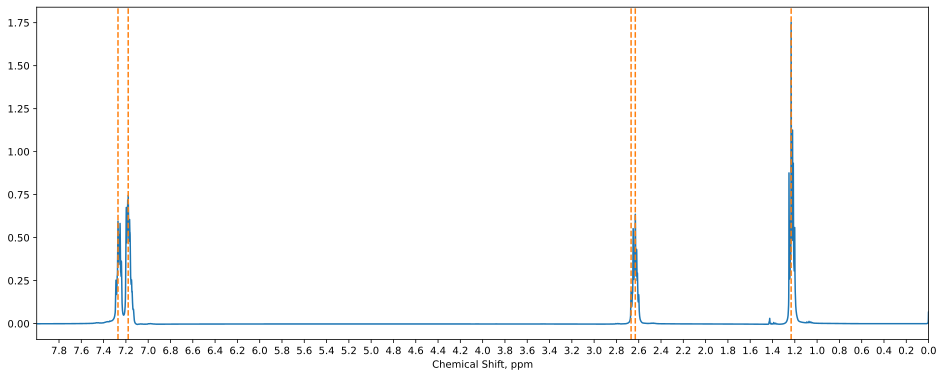

In [27]:
fig9 = plt.figure(figsize=(16, 6))
ax9 = fig9.add_subplot(1, 1, 1)
ax9.plot(ppm_scale, data_ref.real)
ax9.set_xlabel('Chemical Shift, ppm')
plt.xlim(8, 0)
plt.xticks(np.arange(0, 8, 0.2))
for p in peak_loc:
    plt.axvline(p, c='C1', ls='--', alpha=1)

We can plot the NMR spectrum with these chemical shifts marked with vertical dotted lines shown above. Looks like it did a pretty good job locating the resonances! If nmrglue fails to properly identify the peaks, there are a number of parameters described in the [nmrglue documentation](https://nmrglue.readthedocs.io/en/latest/reference/generated/nmrglue.analysis.peakpick.pick.html#nmrglue.analysis.peakpick.pick) that can be adjusted.

(11.2)=
## 11.2 Simulating NMR with nmrsim

nmrsim is a Python package for simulating NMR spectra based on information such as the chemical shifts, coupling constants, and number of coupling nuclei. The package is capable of simulating individual first-order and second-order splitting patterns or enitre NMR spectra. It can also simulate dynamic NMR caused by nuclei rapidly exchanging. nmrsim is [installable using `pip`](https://nmrsim.readthedocs.io/en/latest/installation.html). The package has a few key functions listed below (Table 3) for simulating first-order multiples, spin systems, and spectra. The `Multiplet()` function is used to simulate a single, first-order resonance such as a 1:2:1 triplet or a doublet-of-doublets while the `SpinSystem()` function simulates two resonance signals belonging to pairs of coupled nuclei. The `Spectrum()` function can generate entire spectra by merging the resonances generated by other functions.

````{margin}
```{note}
nmrsim is still in beta, so significant changes to the library may occur in future updates.
```
````


**Table 3** Select nmrsim Simulation Functions

|  Function  | Description  | 
| :---: | :--------    |
|`Multiplet()` | Simulates a single, first-order multiple |
|`SpinSystem()` | Simulates sets of first- or second-order multiplets generated by coupled nuclei|
|`Spectrum()` | Simulates first-order spectra |

(11.2.1)=
### 11.2.1 Simulating First-Order Multiplets

As an example, we can simulate a the signal of methylene (i.e., -CH$_2$-) protons in CH$_3$-CH$_2$-CH-. Let us assume that the methyl/methylene protons have coupling constants of *J* = 7.8 Hz the methine/methylene protons have a coupling constant of *J* = 6.1 Hz. First, we need to import the `Multiplet()` function along with the `mplplot()` plotting function. The `Multiplet()` fuction takes the resonance frequency in Hz (`v`) as the first positional argument followed by the intensity (`I`) of the resonance signal. This can simply be the number of nuclei the signal represents and is only really important when generating entire spectra with multiple signals so that signals that represent more nuclei have a larger area. Finally, coupling constants(`J`)/number of nuclei (`n_nuc`) pairs is provided as a list of tuples, list of lists, or 2D array.

~~~python
Multiplet(v, I, [(J, n_nuc), (J, n_nuc)])
~~~

The `Multiplet()` function generates a Multiplet object which can produce a peak list using the `peaklist()` method. The peak list is simply a list of tuples with (`v`, `I`) pairs for each peak in the multiplet.

In [29]:
from nmrsim import Multiplet
from nmrsim.plt import mplplot

In [30]:
mult = Multiplet(500, 2, [(7.8, 3),(6.1, 1)])
mult

In [31]:
mult_peaks = mult.peaklist()
mult_peaks

[(485.25000000000006, 0.125),
 (491.3500000000001, 0.125),
 (493.05, 0.375),
 (499.15000000000003, 0.375),
 (500.84999999999997, 0.375),
 (506.95, 0.375),
 (508.6499999999999, 0.125),
 (514.7499999999999, 0.125)]

Next we need to visualize this data. For this, nmrsim provides multiple plotting functions built off of matplotlib. We will focus on the `mplplot()` function which accepts the peaklist and generates the line shapes for the actual peaks.

~~~python
x, y = mplplot(peaklist, w=1, y_min=-0.01, y_max=1, limits=(min, max), points=800) 
~~~

There are a number of optional, keyword arguments such as line width (`w`), *y*-axis limits (`y_min` and `y_max`), *x*-axis limits (`limits`), and number of points in the multiplet (`points`). The `mplplot()` function will return the *x-* and *y*-coordinates for the plot. To suppres this, either end the line with a `;` or give it a pair of variables to store these data.

````{margin}
```{tip}
If the splitting pattern does not look quite right, consider increasing the number of points because undersampling can lead to anomalous looking signals.
```
````

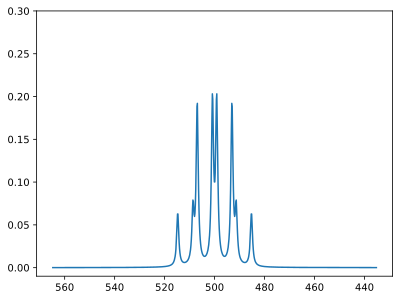

In [32]:
freq, intens = mplplot(mult_peaks, y_max=0.3)

Below is the same splitting pattern with the line width tripled.

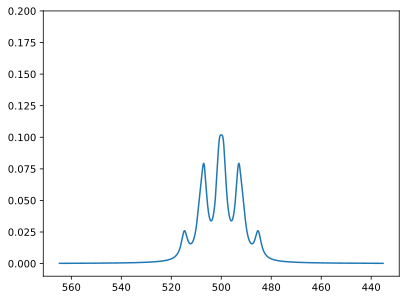

In [33]:
mplplot(mult_peaks, y_max=0.2, w=3);

As another option, we can overlay the multiplet with lines showing the exact chemical shift and intensity ratio of each peak. This can be done either using your plotting library of choice or using the `mplplot_stick()` function in nmrsim. Below the intensity of the stem plot is reduced by a fifth to keep the lines inside the blue splitting pattern.

<StemContainer object of 3 artists>

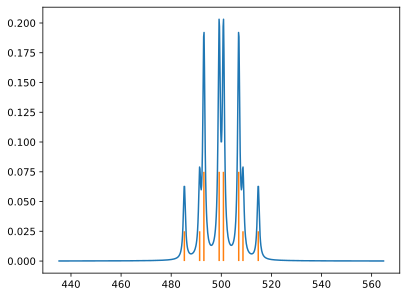

In [34]:
peaks = np.array(mult_peaks)

plt.plot(freq, intens)
plt.stem(peaks[:,0], peaks[:,1]/5, linefmt='C1', basefmt=' ', markerfmt=' ')

(11.2.2)=
### 11.2.2 Simulating Spectra

Entire NMR spectra can be simulated from the component resonance signals -  either Multiplet or SpinSystem objects. Down below, we simulate the signals for the methyl, ethyl, and -OH from ethanol with a *J*=7.3 Hz. Because the -OH peak is broader due to exhange, the width of the resonance is increased by setting `w=3`. The three resonances are then combined into a single spectrum using the `Spectrum()` function which accepts the resonances in a list and also optionally accepts minimum (`vmin=`) and maximum (`vmax`) frequency ranges for the spectrum in Hz.

```{tip}
A spectrum can also be created by adding the resonance signals together with the `+` operator like below.

~~~python
spec = methyl + ethyl + OH
~~~
```

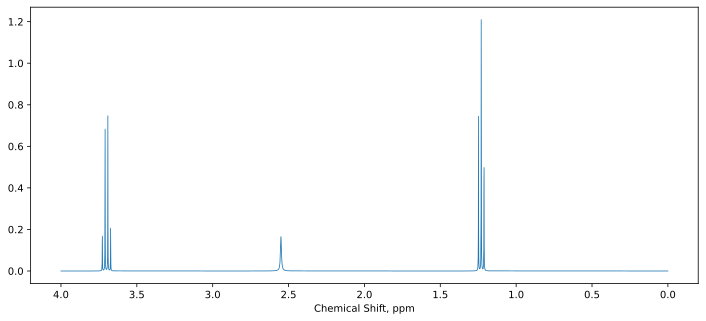

In [35]:
from nmrsim import Spectrum

# create resonances
methyl = Multiplet(492, 3, [(7.3, 2)])
ethyl = Multiplet(1480, 2, [(7.3, 3)])
OH = Multiplet(1020, 1, [], w=3)

# build spectrum
spec = Spectrum([methyl, ethyl, OH], vmin=0, vmax=1600)
v_spec, I_spec = spec.lineshape(points=4000)

# convert from Hz to ppm scale on a 400 MHz spectrometer
v_spec_ppm = v_spec / 400

plt.figure(figsize=(12, 5))
plt.plot(v_spec_ppm, I_spec, linewidth=0.8)
plt.xlabel('Chemical Shift, ppm')
plt.gca().invert_xaxis()

The simulation even exhibits the second-order roofing effect where coupled resonances 'lean' towards each other.

(11.2.3)=

### 11.2.3 Simulate Second-Order Resonances

````{margin}
```{tip}
The `SpinSystem()` function can also simulate second-order signals with a default setting of `second_order=False`.
```
```````

nmrsim is capable of simulating second-order splitting patterns using the following functions (Table 4). The name of each function is based on the Pople nomation where letters adjacent to each other in the alphabet represent resonances that are near each other in a spectrum (e.g., A and B), letters far apart in the alphabet represent resonances further part in the spectrum (e.g., A and X), the same letter is used to represent chemically equivalent nuclei, and primes are used to differentiate chemical equivalent nuclei that are magnetically inequivalent (e.g., A and A').

**Table 4** Second-Order Simulation Functions

|  Function  | Description  | 
| :---: | :--------    |
|`AB()` | Simulates an AB system |
|`AB2()` | Simulates an AB$_2$ system |
|`ABX()` | Simulates an ABX system |
|`ABX3()` | Simulates an ABX$_3$ system |
|`AAXX()` | Simulates an AA'XX' system |
|`AABB()` | Simulates an AA'BB' system |

These functions typically accept the coupling constants (e.g., `Jab=`), the distance between the two nuclei (e.g., `Vab=`), and the chemical shift of the signal in Hz (`Vcentr=`). As a demonstration, below we will simulate an AB spin system where the two nuclei are coupled with *J*=10.0 Hz and separation between the two signals of 9.0 Hz.

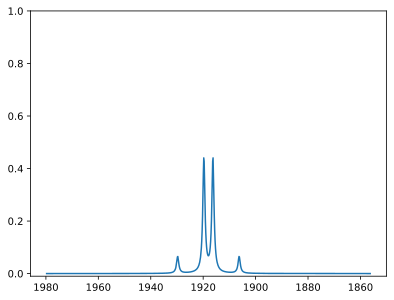

In [36]:
from nmrsim.discrete import AB

res = AB(10, 9, 1918)
mplplot(res);

If we increase the distance between the two nuclei to 30.0 Hz, not only do the two signals become futhure apart, but the second-order character, unevenness in this case, decreases. It is important to note that when measuring the distance between the two second-order signals like this, the center of a doublet with uneven heights is not the center of the doublet but rather a weighted frequency average of the two peaks based on intensities. This means the chemical shift of a doublet is closer to the larger of the two peaks in the doublet.

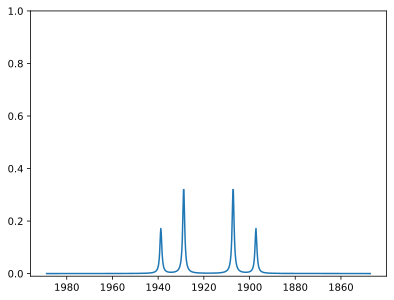

In [37]:
res = AB(10, 30, 1918)
mplplot(res);

(11.2.4)=

### 11.2.4 Dynamic NMR Simulations

Nuclei in some molecules can exchange with each other at observable rates. At lower temperatures, the exchange is relatively slow leading to two distinct and reasonably sharp signals representing the two environments of the exchaning nuclei. As the temperature is increased, the exchanges becomes more rapid causing the two signals to broaden and become closer until they merge into a single peak and ultimately sharpen. There are two dynamic NMR functions in the nmrsim.dnmr module: the `dnmr_two_singlets()` function which simuluates two exchanging nuclei (or groups of chemically equivalent nuclei) that are not coupling with each other while the `dnmr_AB()` function simulates two exchangin nuclei that couple with each other. Below we will simulate two non-coupled, singlet signals exchaning with either other. The required areguments are the chemical shift frequencies of the two nuclei during slow exchange (`va` and `vb`), the exchange rate constant in Hz (`k`), the half-height width of the peaks at slow exchange (`wa` and `wb`), and the fraction of the nulei in position *a* (`pa`). Optionally, you can specify the frequency limits for the generated line shape (`limits=`) and number of data point (`points=`). 

~~~python
v, I = dnmr_two_singlets(va, vb, k, wa, wb, pa, limits=(min, max), point=800)
~~~

Below is a simulation with a rate constant of 70 Hz.

In [38]:
from nmrsim.dnmr import dnmr_two_singlets

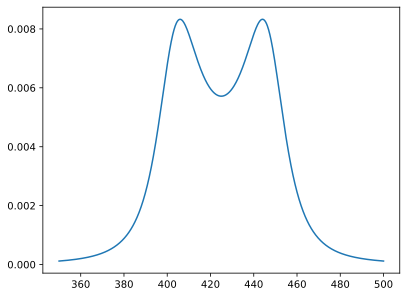

In [39]:
v, I = dnmr_two_singlets(400, 450, 70, 2, 2, 0.5)
plt.plot(v, I)

## Further Reading

1. NMRglue Website. [https://www.nmrglue.com/](https://www.nmrglue.com/) (free resource)

2. NMRglue Documentation Page. [http://nmrglue.readthedocs.io/en/latest/tutorial.html](https://www.nmrglue.com/) (free resource)

3. J.J. Helmus, C.P. Jaroniec, Nmrglue: An open source Python package for the analysis of multidimensional NMR data, J. Biomol. NMR 2013, 55, 355-367, http://dx.doi.org/10.1007/s10858-013-9718-x. (paper on nmrglue)

4. nmrsim Documentation Page. [https://nmrsim.readthedocs.io/en/latest/introduction.html](https://nmrsim.readthedocs.io/en/latest/introduction.html) (free resource)

5. American Chemical Society Division of Organic Chemistry, Hans Reich's NMR Spectroscopy Collection. [https://organicchemistrydata.org/hansreich/resources/nmr/?page=nmr-content%2F](https://organicchemistrydata.org/hansreich/resources/nmr/?page=nmr-content%2F) (free resource)

## Exercises

Complete the following exercises in a Jupyter notebook and NMRglue library. Any data file(s) refered to in the problems can be found in the [data](https://github.com/weisscharlesj/SciCompforChemists/tree/master/notebooks) folder in the same directory as this chapter's Jupyter notebook. Alternatively, you can download a zip file of the data for this chapter from [here](https://github.com/weisscharlesj/data_SciCompforChem) by selecting the appropriate chapter file and then clicking the **Download** button.

1. Open the $^1$H NMR spectrum of ethanol, **EtOH_1H_NMR.fid**, taken in CDCl$_3$ with TMS using NMRglue. Use the `pipe` module.

    a) Plot the resulting spectrum and be sure to properly reference it if not done already.
    
    b) Integrate the methyl (-CH$_3$) versus the methylene (-CH$_2$-) resonances and calculate the ratio.


2. Open the $^1$H and $^{13}$C NMR spectra of 2-ethyl-1-hexanol, **2-ethyl-1-hexanol_1H_NMR_CDCl3.fid** and **2-ethyl-1-hexanol_13C_NMR_CDCl3.fid**, in CDCl$_3$ with TMS and plot them on a ppm scale. Be sure to properly phase and reference the spectra if not done already. Use the `pipe` module.

3. Simulate a first-order doublet of triplets with *J*=5.6 Hz and *J*=9.2 Hz, respectively.

4. Select an article from the [*Journal of Organic Chemistry*](https://pubs.acs.org/journal/joceah) or some other journal and simulate an NMR spectrum with coupling (e.g., not $^{13}$C{$^1$H}) based on data listed in the experimental section. *Note*: some articles are free to access even if you do not have a subscription. Just accesss the most recent issue, and the free articles are marked "Open Access" in ACS journals.

5. Simulate a second-order AA'BB' simulation with a *J*$_{AA'}$ = 15.0 Hz, *J*$_{BB'}$ = 15.0 Hz, *J*$_{AB}$ = 7.0 Hz, *J*$_{AB'}$ = 7.0 Hz and a separation of 27.0 Hz. Compare your simulate to what is shown on [Hans Reich's figure](https://organicchemistrydata.org/hansreich/resources/nmr/?page=05-hmr-15-aabb%2F) (first set of NMR spectra on the page). 